<a href="https://colab.research.google.com/github/leticiaram/Modelacion-Epidemiologica/blob/main/3_Ejemplos_de_Metropolis_Hasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejemplos de inferencia de regresión con Metropolis-Hasting


### Librerias Comunes a ambos ejemplos

In [49]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

from matplotlib import pyplot as plt

## **Inferencia de modelo simple**

In [2]:
from scipy.stats import poisson

Consideremos el modelo Poisson del cual obtenemos una muestra aleatoria. Queremos estimar el parámetro del modelo usando Metropolis Hasting.

A continuación simularemos datos de la m.a. con $X_1, \ldots,X_n$ con distribución Poisson$(\theta)$.

### Creamos datos sintéticos

In [2]:
np.random.seed(10)  #Establecemos semilla para reproducibilidad

N = 100
par = 3
dat = np.random.poisson(size = N, lam = par)

dat

array([1, 4, 2, 2, 5, 3, 4, 5, 1, 2, 4, 4, 2, 2, 6, 2, 1, 3, 3, 0, 6, 2,
       2, 3, 5, 3, 4, 3, 2, 1, 3, 3, 2, 1, 2, 5, 7, 2, 2, 3, 3, 0, 0, 4,
       7, 3, 3, 4, 1, 2, 4, 3, 5, 4, 2, 0, 1, 3, 2, 4, 3, 4, 3, 2, 4, 3,
       4, 4, 7, 4, 5, 2, 1, 6, 1, 4, 1, 3, 2, 3, 1, 2, 1, 3, 2, 5, 6, 2,
       6, 1, 3, 3, 2, 4, 5, 2, 4, 0, 2, 1])

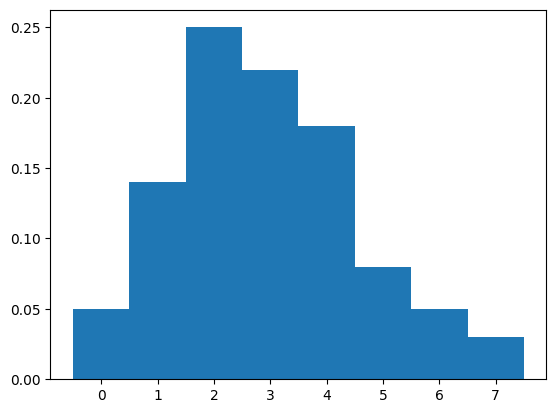

In [4]:
plt.hist(dat, density = True,bins=np.arange(np.min(dat)-0.5,np.max(dat)+1.5,1))
plt.show()

### Estimador Maximo verosimil

In [5]:
np.mean(dat)

2.93

### Metropolis-Hasting


La principal función a especificar es la log-posterior del parámetro $\theta$. Esta la construimos considerando la log-verosimilitud Poisson y la distribucion previa de $\theta$ como Gamma$(\alpha,\beta)$.


\begin{align}
\ell(\boldsymbol{x})&=\left(\sum x_i\right)\log(\theta)-\theta n+c_1\\
\log(\pi(\theta))&=(\alpha-1)\log(\theta)-\frac{\beta}{\theta}+c_2\\
\end{align}

Entonces la log posterior es
$$
\log(\pi(\theta))=\ell(\boldsymbol{x})+\log(\pi(\theta)).
$$

### Graficamos la distribución previa

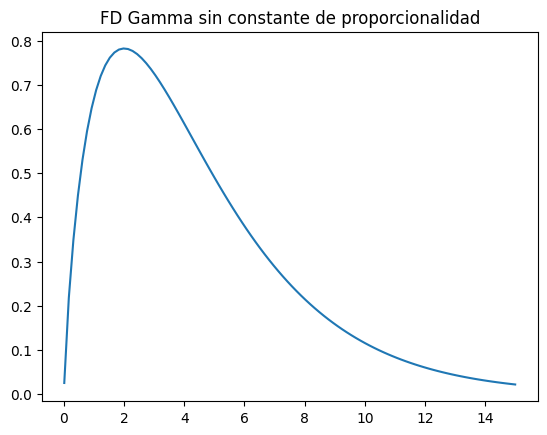

In [3]:
alfa = 1.8
beta = 2.5
x = np.linspace(0.01, 15, 100)
fprev = x**(alfa-1) * np.exp(-x/beta)
plt.plot(x, fprev)
plt.title("FD Gamma sin constante de proporcionalidad")
plt.show()

#### Función log posterior

In [4]:
def log_posterior_Pois(dat, theta):
    """ Args:
        y (numpy.ndarray): The random sample data
        theta (float): The parameter beta to be estimated
        Returns:
        float: The log posterior value
    """
    # Hyperparametros de la previa:
    prioralpha = 2
    priorbeta = 1.5

    log_likelihood = np.sum(dat)*np.log(theta) - theta * len(dat)
    log_prior_theta = (prioralpha - 1) * np.log(theta) - priorbeta / theta

    return log_likelihood + log_prior_theta

#### Función de actualización

In [5]:
def update(i, dat, theta, sigma_scale):
    """ Args:
        i (int): Iterator argument.
        y (numpy.ndarray): Datos
        theta (numpy.ndarray): El parametro theta a estimar
        theta_scale (float): The standard deviation for the proposal distribution.
        Returns:
        float: Updated theta.
    """
    candidate_log_pos = previous_log_pos = 0

    theta_candidate = np.random.normal(theta[i-1], theta_scale)

    if theta_candidate < 0:
        accept = False
    else:
        log_alfa = (
            log_posterior_Pois(dat = dat, theta = theta_candidate) -
            log_posterior_Pois(dat = dat, theta = theta[i-1])
        )
        unidraw = np.random.uniform()
        accept = unidraw < min(np.exp(log_alfa), 1)
    # regresamos el valor de theta y la log verosimilitud (para identificar MAP)
    if accept:
        return theta_candidate, log_posterior_Pois(dat = dat, theta = theta_candidate)
    else:
        return theta[i-1], log_posterior_Pois(dat = dat, theta = theta[i-1])

#### Estimación

##### Inicialización

In [6]:
nsim = 5000    # Número de simulaciones
theta = np.ones(nsim)
log_pos = np.ones(nsim)

##### Tunning parameters

In [7]:
# Define sigma_scale
theta_scale = 0.9

##### Ciclos para obtener la cadena

In [8]:
log_pos[0] = -1e6
for i in range(1, nsim):
    theta[i], log_pos[i] = update(i, dat, theta, theta_scale)

##### Grafica de la cadena

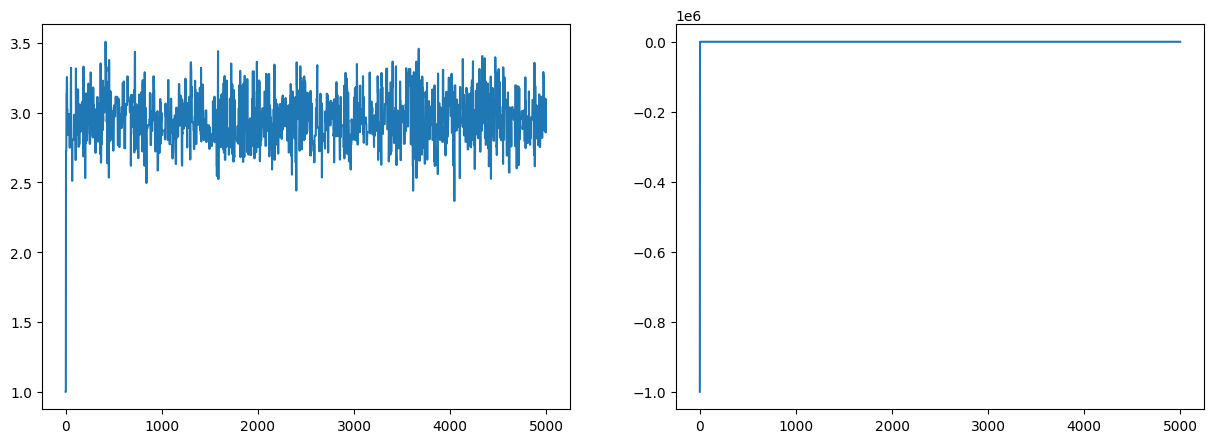

In [9]:
plt.figure(figsize=(15, 5), facecolor='w', edgecolor='k')
plt.subplot(121)
plt.plot(theta)
plt.subplot(122)
plt.plot(log_pos)

##### Calentamiento

In [10]:
warmup = 1000

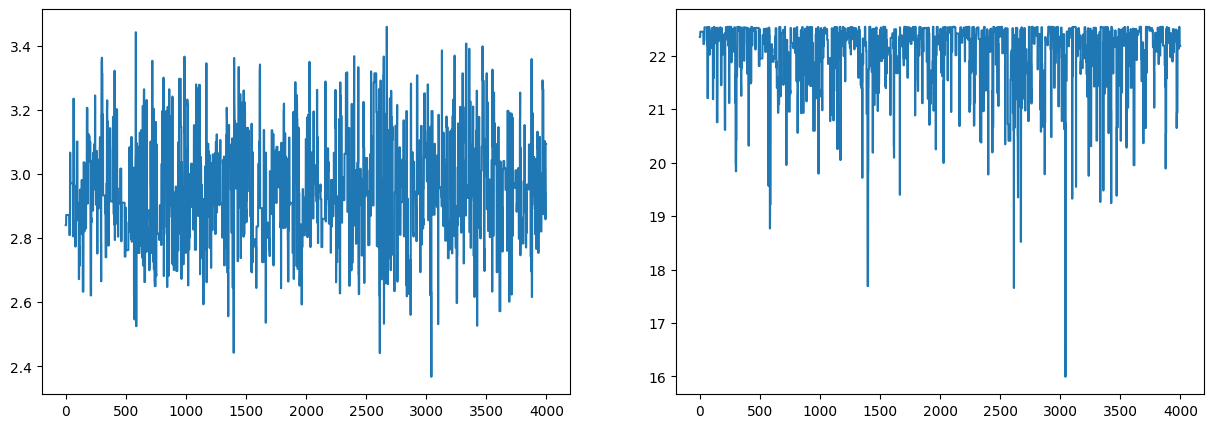

In [11]:
plt.figure(figsize=(15, 5), facecolor='w', edgecolor='k')
plt.subplot(121)
plt.plot(theta[warmup+1:nsim])
plt.subplot(122)
plt.plot(log_pos[warmup+1:nsim])

##### Tasa de aceptación

In [12]:
# Calculate acceptance rates
theta_acc_rate = np.mean(np.diff(theta[warmup+1:nsim]) != 0)

print(f'theta acceptance rate: {theta_acc_rate}')


theta acceptance rate: 0.2388694347173587


##### Autocorrelación y Adelgazamiento

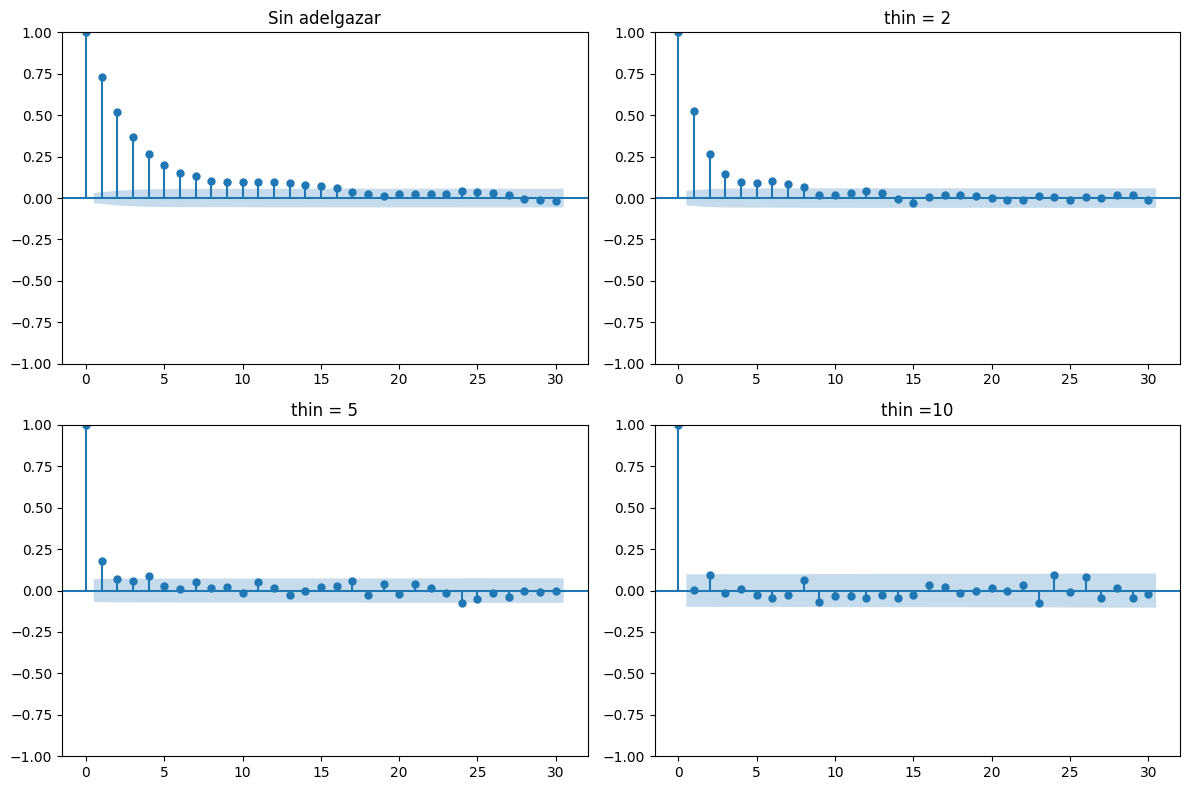

In [13]:
from statsmodels.graphics.tsaplots import plot_acf

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

plot_acf(theta[warmup+1:nsim], lags=30, ax=axs[(0,0)])
axs[(0,0)].set_title('Sin adelgazar')

plot_acf(theta[warmup+1:nsim:2], lags=30, ax=axs[(0,1)])
axs[(0,1)].set_title('thin = 2')

plot_acf(theta[warmup+1:nsim:5], lags=30, ax=axs[(1,0)])
axs[(1,0)].set_title('thin = 5')

plot_acf(theta[warmup+1:nsim:10], lags=30, ax=axs[(1,1)])
axs[(1,1)].set_title('thin =10')

# Adjust layout
plt.tight_layout()
plt.show()

##### Adelgazamiento

Con calentamiento de 1000 y adelgazamiento de 10, el tamaño de la muestra efectivo es

In [14]:
len(theta[warmup+1:nsim:10])

400

#### Simulaciones finales

In [15]:
thin = 10
# Get final chains
theta_mcmc = theta[warmup+1:nsim:thin]
theta_log_pos_mcmc = log_pos[warmup+1:nsim:thin]

##### Resumen

In [16]:
# Convert to pandas DataFrame for summary statistics
theta_mcmc_df = pd.DataFrame(theta_mcmc)

# Get summaries
theta_summary = theta_mcmc_df.describe()

print("Summary of theta_mcmc:")
print(theta_summary)


Summary of theta_mcmc:
                0
count  400.000000
mean     2.942239
std      0.165564
min      2.442795
25%      2.828020
50%      2.933673
75%      3.050748
max      3.366901


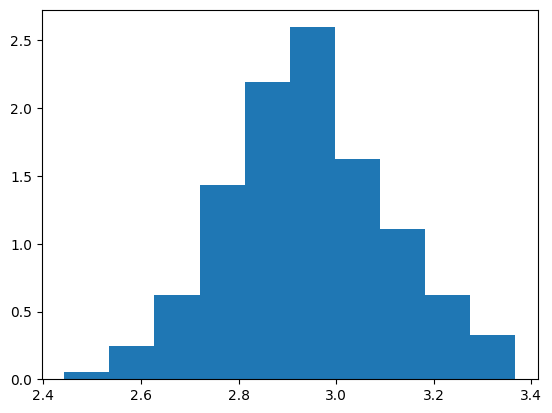

In [17]:
plt.hist(theta_mcmc, density = True)
plt.show()

##### Grafica previa y posterior

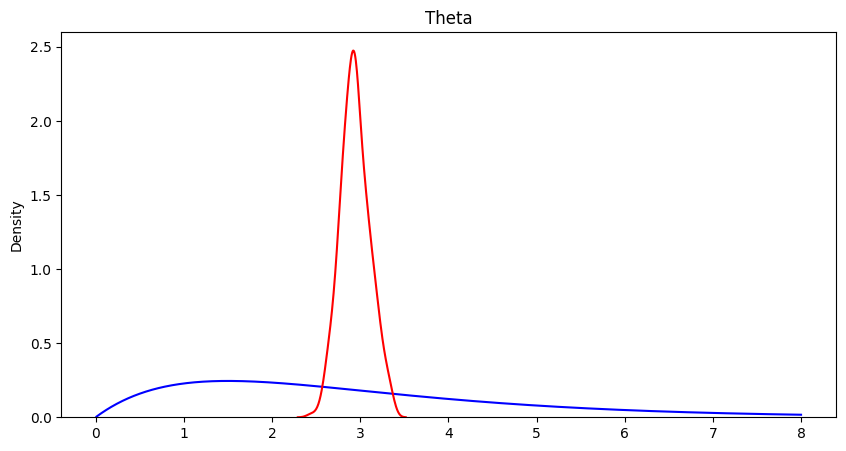

In [23]:
from scipy.stats import norm
from scipy.stats import gamma
import seaborn as sns

# Hyperparametros de la previa:
prioralpha = 2
priorbeta = 1.5

xx = np.linspace(0.01, 8, 1000)

# Calculate the PDF values for the prior or theta
pdf_values_theta = gamma.pdf(xx, prioralpha, scale = priorbeta)

# Create subplots
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.plot(xx, pdf_values_theta, label=f'Previa theta', color='blue')
axs.set_title('Theta')

# Plot histogram with relative frequency
# sns.histplot(data, bins=30, kde=False, stat='density', color='blue', alpha=0.6, label='Histogram')
# Plot KDE
sns.kdeplot(theta_mcmc, color='red', label='KDE', ax=axs)
#plt.grid(True)

plt.show()

##### Intervalos de credibilidad (percentiles)

In [24]:
# Calculate the 95% credible intervals
theta_lower_bounds = np.percentile(theta_mcmc, 2.5, axis=0)
theta_upper_bounds = np.percentile(theta_mcmc, 97.5, axis=0)
print('theta_2.5=',  theta_lower_bounds)
print('theta_97.5=', theta_upper_bounds)

theta_2.5= 2.625016869666154
theta_97.5= 3.2903082240336303


##### Estimadores puntuales

###### Media

In [28]:
theta_mean = np.mean(theta_mcmc)
print(theta_mean)

2.9422389264669766


###### MAP

In [27]:
id_max = np.argmax(theta_log_pos_mcmc)
print(id_max)
theta_map = theta_mcmc[id_max]
print(theta_map)

153
2.945789012204569


##### Gráfica de intervalo y estimadores puntuales

<ipython-input-44-91ce06bba1c7>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f''])


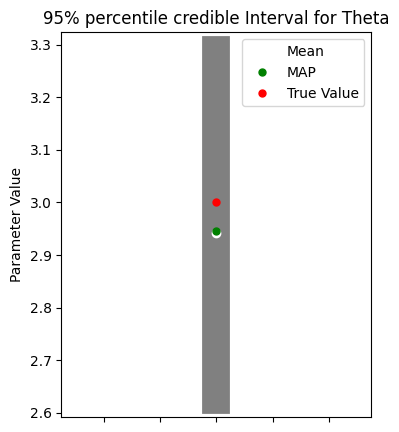

In [44]:
# Plot the credible intervals and true parameter values
fig, ax = plt.subplots(1, 1, figsize=(4, 5))

# Plot credible intervals
ax.plot([0, 0], [theta_lower_bounds, theta_upper_bounds], color='grey', linestyle='-', linewidth=20)
ax.plot(0, theta_mean, 'o', color='white', label='Mean')
ax.plot(0, theta_map, 'o', color='green', markersize=5, label='MAP')
ax.plot(0, par, 'o', color='red', markersize=5, label='True Value')

# Customize the plot
ax.set_xticklabels([f''])
ax.set_ylabel('Parameter Value')
ax.set_title('95% percentile credible Interval for Theta')
ax.legend()

plt.show()

-------------------------------------------------------

## **Inferencia de modelo de regresión**

Código basado en
https://m-clark.github.io/models-by-example/metropolis-hastings.html

In [50]:
from scipy.stats import invgamma
from scipy.stats import multivariate_normal

Para este ejemplo consideramos el modelo
$$
y=\beta_0+\beta_1X_1+\beta_2X_2+\beta_3X_3+\epsilon
$$
Los elementos $X_1,X_2$ y $X_3$ son conocidos, así que para establecer la relación entre estas (que denominamos covariables) y la variable de interés $y$, debemos estimar los valores de los parámetros $\beta_0,\beta_1,\beta_2,\beta_3$. Por otro lado $\epsilon$ es una v.a. que describe la variabilidad de $y$ alrededor de $\beta_0+\beta_1X_1+\beta_2X_2+\beta_3X_3$ y comunmente se asume que $\epsilon\sim N(0,\sigma^2)$, por lo que otro parámetro a estimar es $\sigma^2$ (aunque no con la misma priorida que las betas).


Cuando se tiene $n$ observaciones de las covariables y $y$, el modelo anterior se escribe en forma matricial como
$$
\boldsymbol{y}=X\times \boldsymbol{\beta} +\boldsymbol{\epsilon},
$$
donde $\boldsymbol{y}=(y_1,\ldots,y_n)^{\top}$, $[X]_{i,\cdot}=(1,X_{i1},X_{i2},X_{i3})$, $\boldsymbol{\beta}=(\beta_0,\beta_1,\beta_2,\beta_3)^{\top}$, $\boldsymbol{\epsilon}=(\epsilon_1,\ldots,\epsilon_n)^{\top}$.



### Creamos datos sintéticos



In [51]:
# Establecemos semilla para replicabilidad
np.random.seed(8675309)

# Matriz N x k matrix de covariables
N = 250
K = 3

covariates = np.random.normal(size=(N, K))
covariate_names = ['X1', 'X2', 'X3']
covariates_df = pd.DataFrame(covariates, columns=covariate_names)

# creamos la matrix de covariables que incluye intercepto
X = sm.add_constant(covariates_df)

# Create a normally distributed variable that is a function of the covariates
coefs = np.array([5, 0.2, -1.5, 0.9])
sigma = 2
mu = X.dot(coefs)
y = np.random.normal(mu, sigma, N)
# Esto es:  y = 5 + .2*X1 - 1.5*X2 + .9*X3 + np.random.normal(0, 2, N)

In [53]:
import seaborn as sns

# Convert numpy array to DataFrame with appropriate column names
array_df = pd.DataFrame(y, columns=['y'])

# Concatenate the DataFrame and the numpy array DataFrame
df = pd.concat([X, array_df], axis=1)
df.head()

,const,X1,X2,X3,y
0,1.0,0.589024,0.733119,-1.162189,0.691284
1,1.0,-0.556816,-0.772488,-0.168221,7.822280
2,1.0,-0.416504,-1.378431,0.749256,5.675723
3,1.0,0.178884,0.694011,-1.978054,2.806164
4,1.0,-0.833814,0.564373,0.312013,3.860575


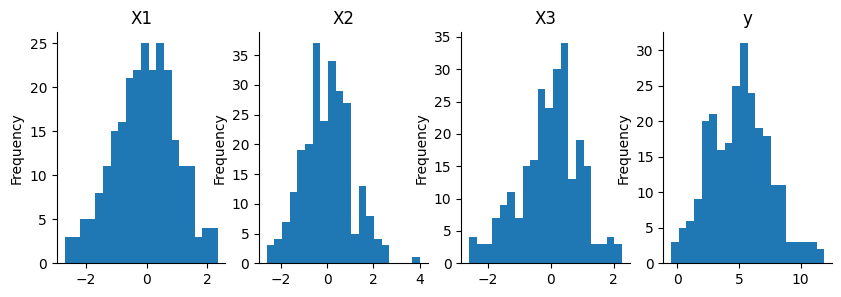

In [54]:

plt.figure(figsize=(10, 3), facecolor='w', edgecolor='k')
plt.subplot(141)
df['X1'].plot(kind='hist', bins=20, title='X1')
plt.gca().spines[['top', 'right',]].set_visible(False)

plt.subplot(142)
df['X2'].plot(kind='hist', bins=20, title='X2')
plt.gca().spines[['top', 'right',]].set_visible(False)

plt.subplot(143)
df['X3'].plot(kind='hist', bins=20, title='X3')
plt.gca().spines[['top', 'right',]].set_visible(False)

plt.subplot(144)
df['y'].plot(kind='hist', bins=20, title='y')
plt.gca().spines[['top', 'right',]].set_visible(False)


<Axes: xlabel='X3', ylabel='y'>

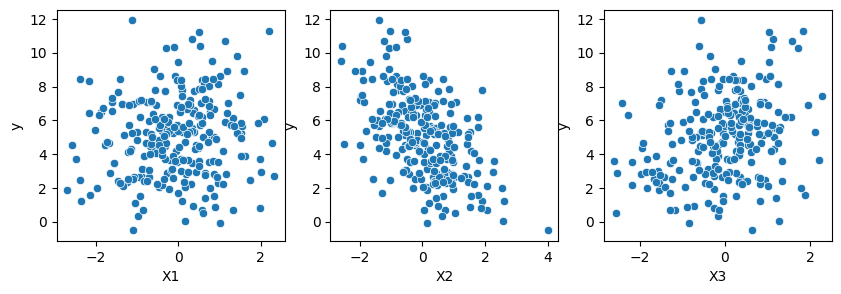

In [55]:
plt.figure(figsize=(10, 3), facecolor='w', edgecolor='k')
plt.subplot(131)
sns.scatterplot(x='X1', y='y', data=df)
plt.subplot(132)
sns.scatterplot(x='X2', y='y', data=df)
plt.subplot(133)
sns.scatterplot(x='X3', y='y', data=df)

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


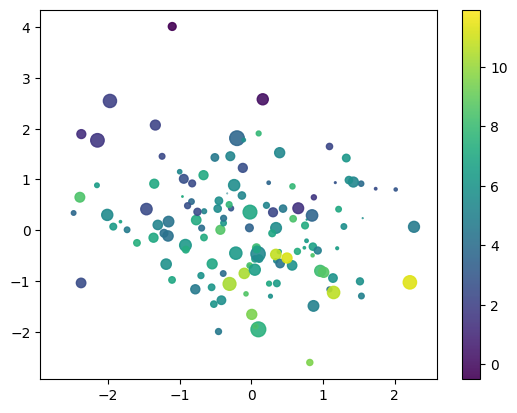

In [56]:
import matplotlib.pyplot as plt
plt.scatter(df['X1'], df['X2'], s=50*df['X3'], c=df['y'], alpha=0.9, cmap='viridis')
plt.colorbar()
plt.show()

### Inferencia clásica de Regresión Lineal

In [57]:
# Run linear regression for later comparison; but go ahead and examine now if desired
fit_lm = sm.OLS(y, X).fit()
print(fit_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     51.54
Date:                Sun, 15 Sep 2024   Prob (F-statistic):           6.96e-26
Time:                        02:28:40   Log-Likelihood:                -512.39
No. Observations:                 250   AIC:                             1033.
Df Residuals:                     246   BIC:                             1047.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1200      0.120     42.623      0.0

### Metropolis-Hasting

Como previas vamos a considerar la distribución Normal Multivariada (NMV($\boldsymbol{\mu}$, $ \boldsymbol{\Sigma}$)) e Inversa Gaussiana (InvGamm($\alpha$, $\gamma$)). Las distribuciones, respectivamente, tienen FDP:
$$
\begin{aligned}
p(\mathbf{x})=&(2 \pi)^{-k / 2} \operatorname{det}(\boldsymbol{\Sigma})^{-1 / 2} \exp \left(-\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^{\mathrm{T}} \boldsymbol{\Sigma}^{-1}(\mathbf{x}-\boldsymbol{\mu})\right)\mathbb{I}_{\mathbb{R}^{m}}\\
\end{aligned}
$$
donde $\boldsymbol{\Sigma}$ es positiva-definida, y
$$
p(x)=\frac{\gamma^\alpha}{\Gamma(\alpha)} x^{-\alpha-1} \exp \left(-\frac{\gamma}{x}\right) \mathbb{I}_{\mathbb{R}^{+}}
$$

La principal función a especificar es la logposterior de los coeficientes $\beta$ y $\sigma^2$. Esta la construimos considerando que las distribuciones previas son independientes y con distribuciones Gaussianas para $\beta$  e inversa gamma para $\sigma^2$.

\begin{align}
\ell(\boldsymbol{x})&=-n/2\log(\sigma^2)-\frac{\sum(y_i-\mu_i)^2}{2\sigma^2}+c_1\\
\log(\pi(\boldsymbol{\beta}))&=-\frac{1}{2}\boldsymbol{\beta}^{\mathrm{T}} \boldsymbol{\Sigma}^{-1}\boldsymbol{\beta}+c_2\\
\log(\pi(\sigma^2))&=-(\alpha+1)\log(\sigma^2)-\frac{\gamma}{\sigma^2}+c_3\\
\end{align}

Entonces la log posterior es
$$
\log(\pi(\boldsymbol{\beta}, \sigma^2))=\ell(\boldsymbol{x})+\log(\pi(\boldsymbol{\beta}))+\log(\pi(\sigma^2)).
$$

#### Función Log posterior

In [58]:
def log_posterior(X, y, b, s2):
    """ Args:
        X (numpy.ndarray): The covariate matrix
        y (numpy.ndarray): The target vector
        b (numpy.ndarray): The parameter beta to be estimated
        s2 (float): The parameter sigma^2 to be estimated
        Returns:
        float: The log posterior value
    """
    beta = b
    sigma2 = s2
    mu = np.dot(X, beta)

    # Hyperparameters of  priors: b ~ N(0, sd = 10), sigma2 ~ invGamma(.001, .001)
    priorbvarinv = np.diag([1/100] * 4) # variance covariance matrix
    prioralpha = priorbeta = 0.001  # parameters for the inverse gamma prior

    if np.isnan(sigma2) or sigma2 <= 0:  # scale parameter must be positive
        return -np.inf
    else:
        log_likelihood = - 0.5 * X.shape[0] * np.log(sigma2) - (0.5 / sigma2) * np.dot((y - mu).T, (y - mu))
        log_prior_beta = - 0.5 * np.dot(np.dot(beta.T, priorbvarinv), beta)
        log_prior_sigma2 = -(prioralpha + 1) * np.log(sigma2) - priorbeta / sigma2

        return log_likelihood + log_prior_beta + log_prior_sigma2

#### Funciones de actualización

In [59]:
def update_coef(i, x, y, b, s2, b_var_scale):
    """ Update step for regression coefficients.
        Args:
        i (int): Iterator argument (index of b and s2 to be calculated).
        x (numpy.ndarray): The model matrix.
        y (numpy.ndarray): The target vector.
        b (numpy.ndarray): The parameter beta to be estimated (it is a vector).
        s2 (numpy.ndarray): The parameter sigma^2 to be estimated (it is a vector).
        b_var_scale (numpy.ndarray): The variance scale for the beta proposal distribution.
        Returns:
        numpy.ndarray: Updated beta coefficients.
    """
    b[i, :] = multivariate_normal.rvs(mean=b[i-1, :], cov = b_var_scale)  # proposal/jumping distribution

    # Compare to past - does it increase the posterior probability?
    post_diff = (
        log_posterior(X=x, y=y, b=b[i, :], s2=s2[i-1]) -
        log_posterior(X=x, y=y, b=b[i-1, :], s2=s2[i-1])
    )

    # Acceptance phase
    unidraw = np.random.uniform()
    accept = unidraw < min(np.exp(post_diff), 1)  # accept if so

    return b[i, :] if accept else b[i-1, :]



def update_s2(i, x, y, b, s2, sigma_scale):
    """ Update step for sigma^2.
        Args:
        i (int): Iterator argument.
        x (numpy.ndarray): The model matrix.
        y (numpy.ndarray): The target vector.
        b (numpy.ndarray): The parameter beta to be estimated.
        s2 (numpy.ndarray): The parameter sigma^2 to be estimated.
        sigma_scale (float): The standard deviation for the sigma^2 proposal distribution.
        Returns:
        float: Updated sigma^2.
    """
    candidate_log_pos = previous_log_pos = 0

    s2_candidate = np.random.normal(s2[i-1], sigma_scale)

    if s2_candidate < 0:
        accept = False
    else:
        s2_diff = (
            log_posterior(X=x, y=y, b=b[i, :], s2=s2_candidate) -
            log_posterior(X=x, y=y, b=b[i, :], s2=s2[i-1])
        )
        unidraw = np.random.uniform()
        accept = unidraw < min(np.exp(s2_diff), 1)

    if accept:
        return s2_candidate, log_posterior(X=x, y=y, b=b[i, :], s2=s2_candidate)
    else:
        return s2[i-1], log_posterior(X=x, y=y, b=b[i, :], s2=s2[i-1])

#### Estimación

##### Inicialización

In [60]:
# Setting  number of simulations
nsim = 5000

# Assuming X is already defined as your model matrix
ncol_X = X.shape[1]

# Initialize beta update matrix, and sigma and log_posterior vector
b = np.zeros((nsim, ncol_X))
s2 = np.ones(nsim)

log_pos = np.ones(nsim)

In [61]:
print("b=",b)
print("s2=",s2)

b= [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 ...
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
s2= [1. 1. 1. ... 1. 1. 1.]


##### Tunning Parameters

In [63]:
import statsmodels.api as sm


# Assuming fit_lm is the fitted linear model object from statsmodels
# Compute the variance-covariance matrix of the coefficients
b_var = fit_lm.cov_params().values

# Scale the variance-covariance matrix
b_var_scale = b_var * (2.4 / np.sqrt(b.shape[1]))**2

# Define sigma_scale
sigma_scale = 0.9

# Print to verify

print("b_var_scale:", b_var_scale)
print("sigma_scale:", sigma_scale)

b_var_scale: [[ 0.02077795  0.00120904 -0.00021323  0.00104408]
 [ 0.00120904  0.02006865  0.00161858  0.00148701]
 [-0.00021323  0.00161858  0.01877157 -0.00119549]
 [ 0.00104408  0.00148701 -0.00119549  0.02296041]]
sigma_scale: 0.9


##### Ciclo para obtener la cadena

In [64]:
log_pos[0] = -1e6
for i in range(1, nsim):
    b[i, :] = update_coef(i, X, y, b, s2, b_var_scale)
    s2[i], log_pos[i] = update_s2(i, X, y, b, s2, sigma_scale)

<ipython-input-59-786bf361f767>:53: RuntimeWarning: overflow encountered in exp
  accept = unidraw < min(np.exp(s2_diff), 1)


##### Graficas de las cadenas

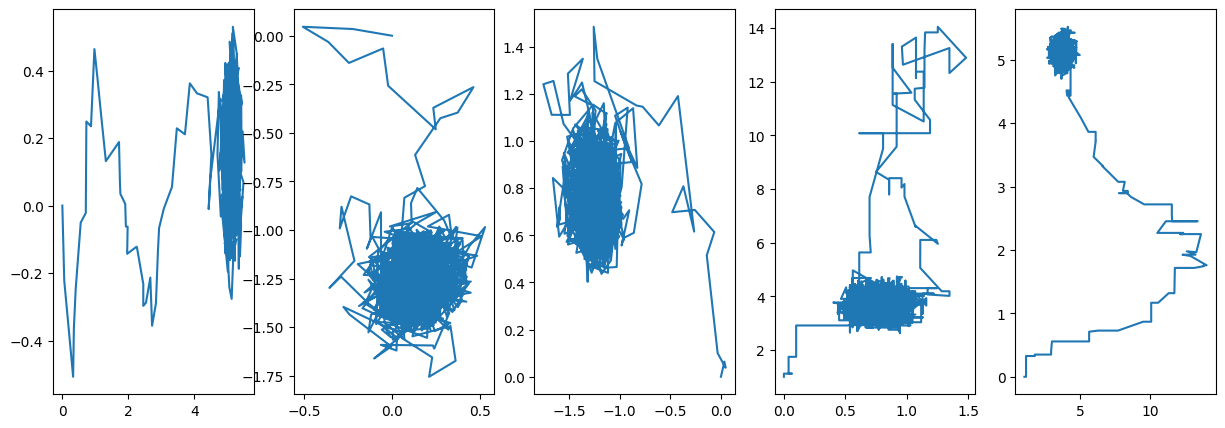

In [65]:
plt.figure(figsize=(15, 5), facecolor='w', edgecolor='k')
plt.subplot(151)
plt.plot(b[:,0],b[:,1])
plt.subplot(152)
plt.plot(b[:,1],b[:,2])
plt.subplot(153)
plt.plot(b[:,2],b[:,3])
plt.subplot(154)
plt.plot(b[:,3],s2)
plt.subplot(155)
plt.plot(s2,b[:,0])

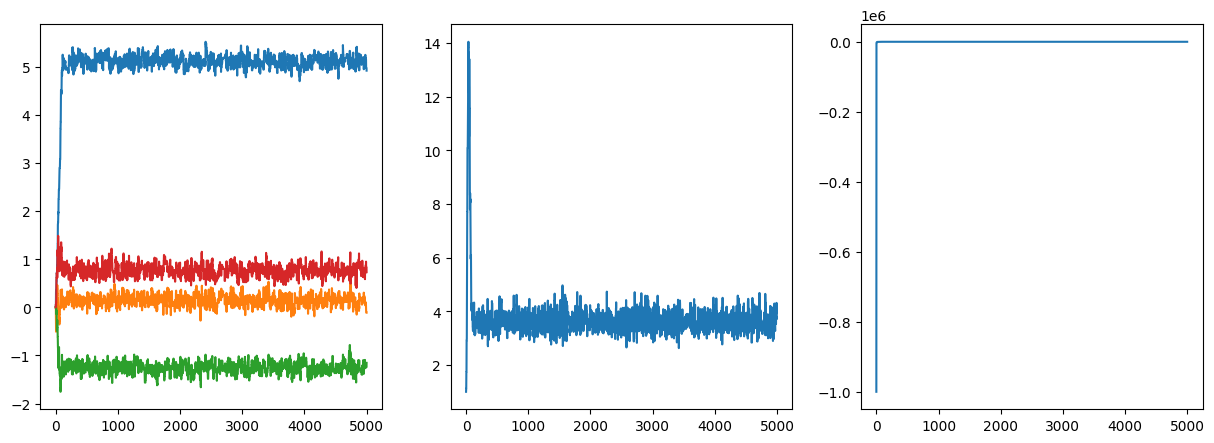

In [66]:
plt.figure(figsize=(15, 5), facecolor='w', edgecolor='k')
plt.subplot(131)
plt.plot(b)
plt.subplot(132)
plt.plot(s2)
plt.subplot(133)
plt.plot(log_pos)

##### Calentamiento y Adelgazamiento de las cadenas

In [67]:
# warmup and thining parameters
warmup = 1000
thin = 10

##### Tasa de aceptación

In [68]:
# Calculate acceptance rates
b_acc_rate = np.mean(np.diff(b[warmup+1:nsim, :], axis=0) != 0)
s2_acc_rate = np.mean(np.diff(s2[warmup+1:nsim]) != 0)

print(f'b acceptance rate: {b_acc_rate}')
print(f's2 acceptance rate: {s2_acc_rate}')

b acceptance rate: 0.2888944472236118
s2 acceptance rate: 0.39394697348674335


#### Simulaciones Finales

In [69]:
b_mcmc = b[warmup+1:nsim:thin, :]
s2_mcmc = s2[warmup+1:nsim:thin]
log_pos_mcmc = log_pos[warmup+1:nsim:thin]

##### Graficas de autocorrelación

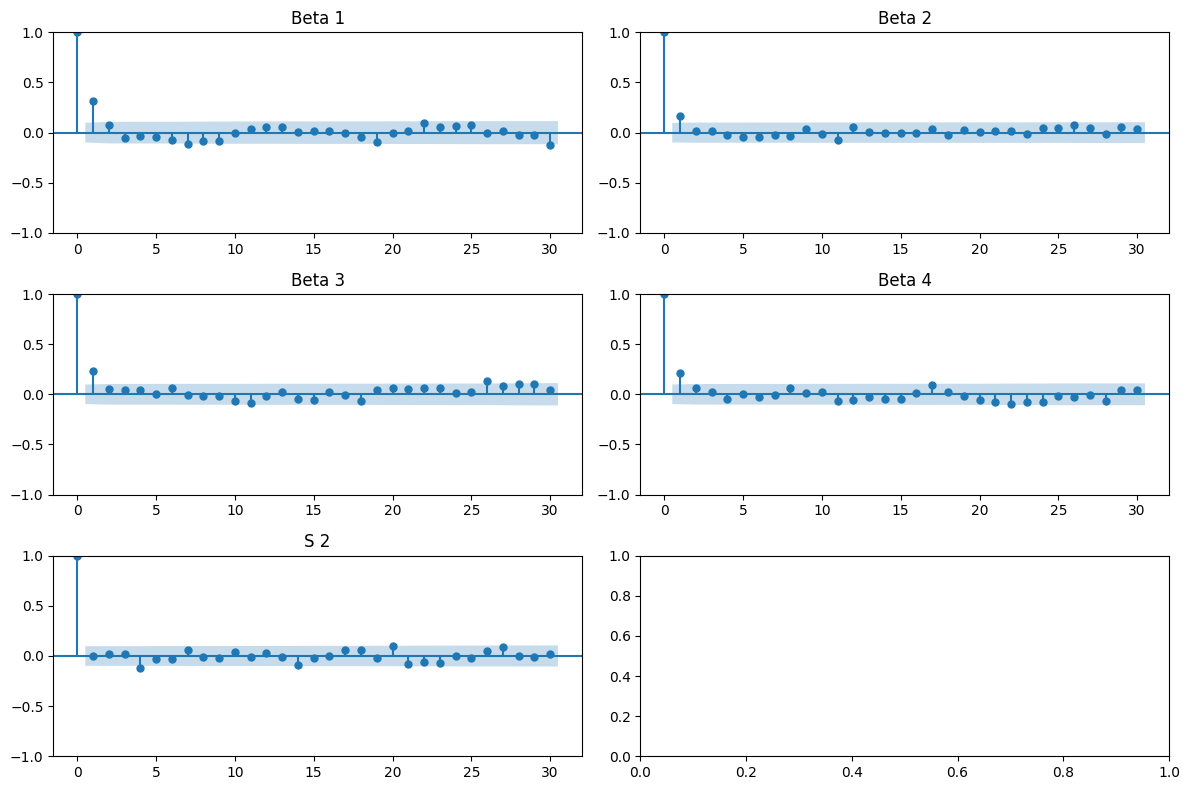

In [70]:
from statsmodels.graphics.tsaplots import plot_acf

# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 8))

plot_acf(b_mcmc[:,0], lags=30, ax=axs[(0,0)])
axs[(0,0)].set_title('Beta 1')

plot_acf(b_mcmc[:,1], lags=30, ax=axs[(0,1)])
axs[(0,1)].set_title('Beta 2')

plot_acf(b_mcmc[:,2], lags=30, ax=axs[(1,0)])
axs[(1,0)].set_title('Beta 3')

plot_acf(b_mcmc[:,3], lags=30, ax=axs[(1,1)])
axs[(1,1)].set_title('Beta 4')

plot_acf(s2_mcmc, lags=30, ax=axs[(2,0)])
axs[(2,0)].set_title('S 2')

# Adjust layout
plt.tight_layout()
plt.show()

##### Resumen

In [71]:
# Convert to pandas DataFrame for summary statistics
b_mcmc_df = pd.DataFrame(b_mcmc, columns=[f'b{i}' for i in range(b.shape[1])])
s2_mcmc_df = pd.DataFrame(s2_mcmc, columns=['s2'])

# Get summaries
b_summary = b_mcmc_df.describe()
s2_summary = s2_mcmc_df.describe()

print("Summary of b_mcmc:")
print(b_summary)

print("\nSummary of s2_mcmc:")
print(s2_summary)

Summary of b_mcmc:
               b0          b1          b2          b3
count  400.000000  400.000000  400.000000  400.000000
mean     5.115979    0.143300   -1.253892    0.761063
std      0.116311    0.114408    0.114543    0.118822
min      4.699197   -0.163081   -1.599172    0.465765
25%      5.046096    0.059882   -1.329138    0.674174
50%      5.116766    0.140811   -1.256006    0.755989
75%      5.190195    0.212414   -1.170707    0.839619
max      5.461023    0.529643   -0.783830    1.119291

Summary of s2_mcmc:
               s2
count  400.000000
mean     3.597188
std      0.329043
min      2.737797
25%      3.377940
50%      3.574205
75%      3.793697
max      4.965880


##### Previa-Posterior

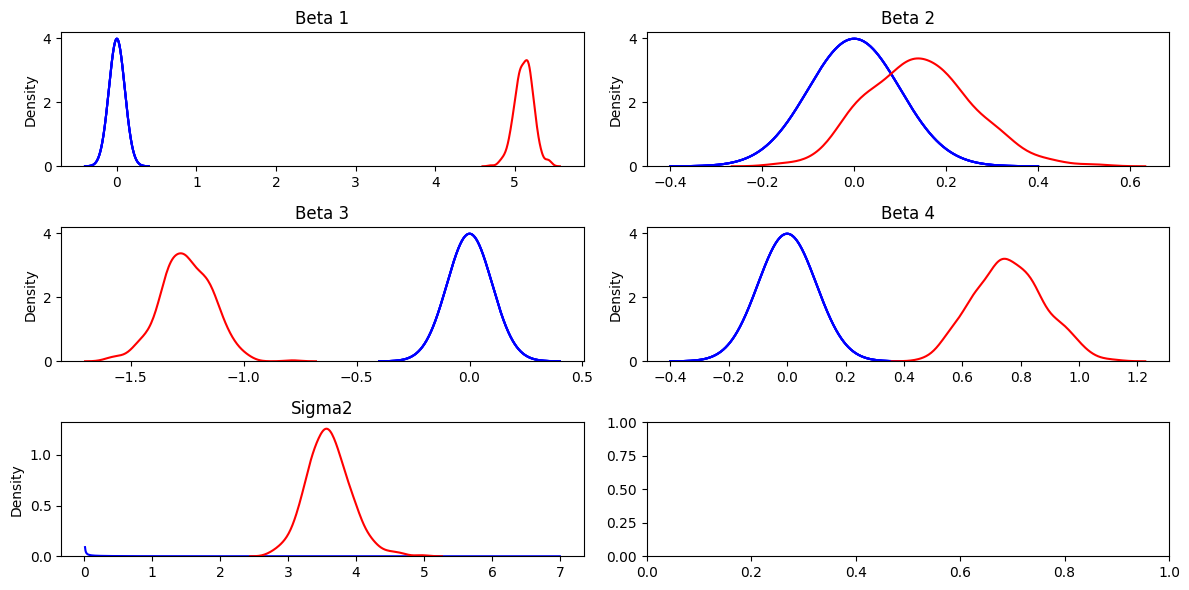

In [74]:
from scipy.stats import norm
from scipy.stats import invgamma
import seaborn as sns

# Parameters of the Gaussian distribution
hyperp_mu = 0      # Mean
hyperp_sigma2 = [1/100] * 4  # Variance
hyperp_sigma = np.sqrt(hyperp_sigma2)  # Standard deviation

# Create a range of values for the x-axis
x = np.linspace(hyperp_mu - 4*hyperp_sigma, hyperp_mu + 4*hyperp_sigma, 1000)

# Calculate the PDF values for the prior or betas
pdf_values = norm.pdf(x, hyperp_mu, hyperp_sigma)


# Parameters of the inverse gamma distribution
hyperp_alpha = 0.001  # Shape parameter (α)
hyperp_beta = 0.001   # Scale parameter (β)

xx = np.linspace(0.01, 7, 1000)

# Calculate the PDF values for the prior or sigma2
pdf_values_s2 = invgamma.pdf(xx, hyperp_alpha, scale=hyperp_beta)

# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 6))

axs[(0,0)].plot(x, pdf_values, label=f'Gaussian PDF\n$\mu={mu}$, $\sigma^2={hyperp_sigma2}$', color='blue')
axs[(0,0)].set_title('Beta 1')
# Plot histogram with relative frequency
#sns.histplot(data, bins=30, kde=False, stat='density', color='blue', alpha=0.6, label='Histogram')
# Plot KDE
sns.kdeplot(b_mcmc[:,0], color='red', label='KDE', ax=axs[0,0])
#plt.grid(True)


axs[(0,1)].plot(x, pdf_values, label=f'Gaussian PDF\n$\mu={mu}$, $\sigma^2={hyperp_sigma2}$', color='blue')
axs[(0,1)].set_title('Beta 2')
sns.kdeplot(b_mcmc[:,1], color='red', label='KDE', ax=axs[0,1])


axs[(1,0)].plot(x, pdf_values, label=f'Gaussian PDF\n$\mu={mu}$, $\sigma^2={hyperp_sigma2}$', color='blue')
axs[(1,0)].set_title('Beta 3')
sns.kdeplot(b_mcmc[:,2], color='red', label='KDE', ax=axs[1,0])

axs[(1,1)].plot(x, pdf_values, label=f'Gaussian PDF\n$\mu={mu}$, $\sigma^2={hyperp_sigma2}$', color='blue')
axs[(1,1)].set_title('Beta 4')
sns.kdeplot(b_mcmc[:,3], color='red', label='KDE', ax=axs[1,1])

axs[(2,0)].plot(xx, pdf_values_s2, label=f'$\sigma^2$', color='blue')
axs[(2,0)].set_title('Sigma2')
sns.kdeplot(s2_mcmc, color='red', label='KDE', ax=axs[2,0])


# Adjust layout
plt.tight_layout()
plt.show()

##### Intervalos de credibilidad (percentiles)

In [75]:
# Calculate the 95% credible intervals
b_lower_bounds = np.percentile(b_mcmc, 2.5, axis=0)
b_upper_bounds = np.percentile(b_mcmc, 97.5, axis=0)
print('b_p2.5=',  b_lower_bounds)
print('b_p97.5=', b_upper_bounds)
s2_lower_bounds = np.percentile(s2_mcmc, 2.5, axis=0)
s2_upper_bounds = np.percentile(s2_mcmc, 97.5, axis=0)
print('s2_p2.5=',  s2_lower_bounds)
print('s2_p97.5=', s2_upper_bounds)

b_p2.5= [ 4.88555363 -0.05664925 -1.4806331   0.54654034]
b_p97.5= [ 5.33658957  0.37480342 -1.03999098  0.99012296]
s2_p2.5= 2.9841105374551034
s2_p97.5= 4.288078367191962


##### Estimadores Puntuales

###### Media

In [76]:
b_means = np.mean(b_mcmc, axis=0)
s2_means = np.mean(s2_mcmc, axis=0)
print(b_means)
print(s2_means)

[ 5.11597945  0.14329979 -1.25389156  0.76106292]
3.5971881043525866


###### MAP

In [77]:
id_max = np.argmax(log_pos_mcmc)
print(id_max)
b_map = b_mcmc[id_max, :]
s2_map = s2_mcmc[id_max]
print(b_map)
print(s2_map)

297
[ 5.11047733  0.09048439 -1.2422118   0.7317883 ]
3.554293003268221


Recordamos que los verdaderos Valores de parámetros son:

In [78]:
b_true = np.array([5, 0.2, -1.5, 0.9])
s2_true = 4

##### Gráfica de Intervalos y estimadores puntuales

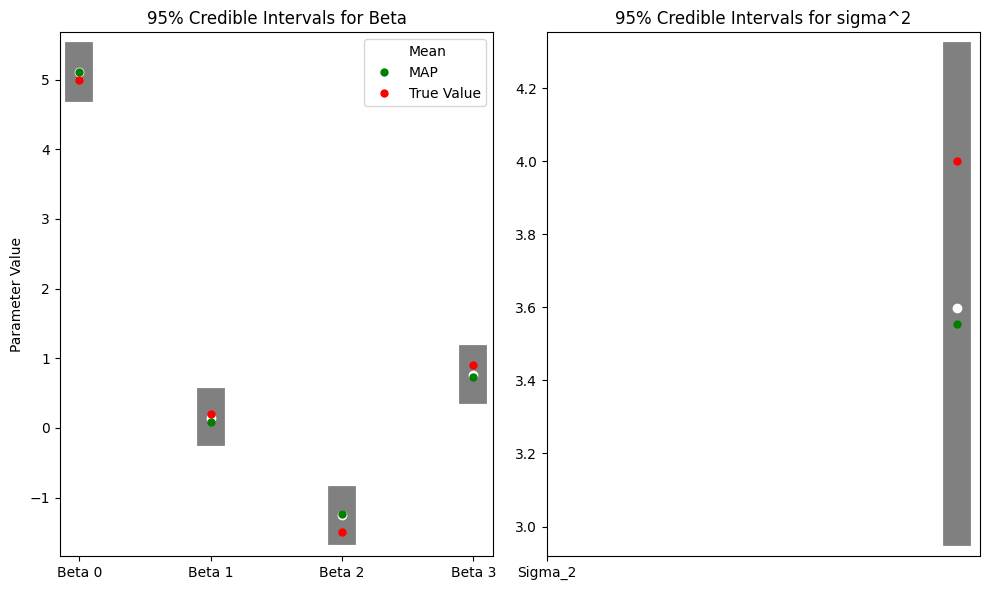

In [79]:
# Plot the credible intervals and true parameter values
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

# Plot credible intervals
for i, (mean, lower, upper, bmap, true) in enumerate(zip(b_means, b_lower_bounds, b_upper_bounds, b_map, b_true)):
    ax[0].plot([i, i], [lower, upper], color='grey', linestyle='-', linewidth=20)
    ax[0].plot(i, mean, 'o', color='white', label='Mean' if i == 0 else "")
    ax[0].plot(i, bmap, 'o', color='green', markersize=5, label='MAP' if i == 0 else "")
    ax[0].plot(i, true, 'o', color='red', markersize=5, label='True Value' if i == 0 else "")

# Customize the plot
ax[0].set_xticks(range(len(b_true)))
ax[0].set_xticklabels([f'Beta {i}' for i in range(len(b_true))])
ax[0].set_ylabel('Parameter Value')
ax[0].set_title('95% Credible Intervals for Beta')
ax[0].legend()


ax[1].plot([i, i], [s2_lower_bounds, s2_upper_bounds], color='grey', linestyle='-', linewidth=20)
ax[1].plot(i, s2_means, 'o', color='white', label='Mean' if i == 0 else "")
ax[1].plot(i, s2_map, 'o', color='green', markersize=5, label='MAP' if i == 0 else "")
ax[1].plot(i, s2_true, 'o', color='red', markersize=5, label='True Value' if i == 0 else "")
ax[1].set_xticks(range(1))
ax[1].set_xticklabels(['Sigma_2'])
ax[1].set_title('95% Credible Intervals for sigma^2')

plt.tight_layout()
plt.show()

